<a href="https://colab.research.google.com/github/sergiomora03/AdvancedTopicsAnalytics/blob/main/exercises/E1-UsedVehiclePricePredictionDeployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# E1 - Model Deployment in Used Vehicle Price Prediction

## Introduction

- 1.2 Million listings scraped from TrueCar.com - Price, Mileage, Make, Model dataset from Kaggle: [data](https://www.kaggle.com/jpayne/852k-used-car-listings)
- Each observation represents the price of an used car

In [8]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_openml
from scikeras.wrappers import KerasRegressor
from evidently import ColumnMapping
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset
from scipy.stats import ks_2samp
import joblib
import os
from flask import Flask
from flask_restx import Api, Resource, fields
from os import stat
from flask import request
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import Ridge, Lasso

In [2]:
data = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/dataTrain_carListings.zip')

In [3]:
data.head()

,Price,Year,Mileage,State,Make,Model
0,21490,2014,31909,MD,Nissan,MuranoAWD
1,21250,2016,25741,KY,Chevrolet,CamaroCoupe
2,20925,2016,24633,SC,Hyundai,Santa
3,14500,2012,84026,OK,Jeep,Grand
4,32488,2013,22816,TN,Jeep,Wrangler


In [5]:
data.shape

(500000, 6)

In [5]:
data.columns

Index(['Price', 'Year', 'Mileage', 'State', 'Make', 'Model'], dtype='object')

# Exercise P0.1 (50%)

Develop a machine learning model that predicts the price of the of car using as an input ['Year', 'Mileage', 'State', 'Make', 'Model']

#### Evaluation:
- 25% - Performance of the models using a manually implemented K-Fold (K=10) cross-validation
- 25% - Notebook explaining the process for selecting the best model. You must specify how the calibration of each of the parameters is done and how these change the performance of the model. It is expected that a clear comparison will be made of all implemented models.. Present the most relevant conslusions about the whole process.


In [4]:
data['Mileage'] = np.log1p(data['Mileage'])

In [5]:
df=data
percentile_95 = df['Price'].quantile(0.95)
df = df[df['Price'] <= percentile_95]

In [6]:
# Filtrar datos hasta 2010
data_train = df[df['Year'] <= 2010]
X = data_train[['Year', 'Mileage', 'State', 'Make', 'Model']]
y = data_train['Price']

In [9]:

# Pipeline de preprocesamiento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Mileage']),  # Estandarizar variables numéricas
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Year', 'State', 'Model', 'Make'])  # Dumificación sin salida densa
    ])

# Definir los modelos con hiperparámetros optimizados
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),  # alpha es el parámetro de regularización
    'Lasso Regression': Lasso(alpha=0.1),  # alpha es el parámetro de regularización
    'Random Forest': RandomForestRegressor(
        n_estimators=100,       # Aumentar el número de árboles
        max_depth=15,           # Aumentar la profundidad máxima
        min_samples_split=5,    # Aumentar el mínimo de muestras para dividir un nodo
        min_samples_leaf=4,     # Aumentar el mínimo de muestras en cada hoja
        max_features='sqrt',    # Usar la raíz cuadrada del número de características
        n_jobs=-1,              # Usar todos los núcleos disponibles
        random_state=42         # Asegurar reproducibilidad
    ),
    'Gradient Boosting': GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),
    'XGBoost': XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
}

# Configurar K-Fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Almacenar el mejor modelo y su rendimiento
best_model = None
best_mse = float('inf')
best_name = ""

# Evaluar cada modelo
for name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),  # Tu preprocesador definido previamente
        ('model', model)
    ])
    
    # Usar procesamiento en paralelo durante la validación cruzada
    scores = cross_val_score(
        pipeline, 
        X, 
        y, 
        cv=kf, 
        scoring='neg_mean_squared_error', 
        n_jobs=-1  # Paralelizar la validación cruzada
    )
    
    mse = -scores.mean()
    std = scores.std()
    print(f"{name} MSE: {mse:.4f} (+/- {std:.4f})")

    if mse < best_mse:
        best_mse = mse
        best_model = pipeline
        best_name = name

print(f"El mejor modelo es: {best_name} con MSE: {best_mse:.4f}")


Linear Regression MSE: 8943236.5806 (+/- 336134.7546)
Ridge Regression MSE: 8945485.1750 (+/- 335660.3707)
Lasso Regression MSE: 8953949.9129 (+/- 334843.7830)
Random Forest MSE: 20794160.3391 (+/- 368419.1063)
Gradient Boosting MSE: 13943654.7897 (+/- 233199.2301)
XGBoost MSE: 13939532.3874 (+/- 242775.5311)
El mejor modelo es: Linear Regression con MSE: 8943236.5806


# Conclusiones 

se evaluaron varios modelos de regresión con el objetivo de predecir la variable objetivo y seleccionar el modelo con mejor rendimiento. Los modelos probados fueron:

Regresión Lineal
Regresión Ridge
Regresión Lasso
Random Forest
Gradient Boosting
XGBoost

Cada uno de estos modelos tiene características específicas que los hacen adecuados para diferentes tipos de datos y complejidades. El enfoque fue calibrar los parámetros clave de cada modelo y analizar cómo estos afectan su rendimiento.

Regresión Lineal: Este fue utilizado como modelo base. No tiene parámetros complejos para ajustar, lo que lo hace sencillo de implementar y sirve como referencia para comparar con otros modelos más complejos.

Regresión Ridge y Lasso:

alpha: Este parámetro controla el grado de regularización que se aplica a los coeficientes. En Ridge, se aplica una penalización L2 que reduce la magnitud de todos los coeficientes, mientras que en Lasso se aplica una penalización L1 que puede llevar algunos coeficientes a cero, actuando como un mecanismo de selección de características.

Impacto en el rendimiento: En este caso, la regularización no mejoró significativamente el rendimiento en comparación con la regresión lineal simple.

Random Forest:

n_estimators: Se incrementó el número de árboles en el bosque para evaluar si mejoraba la precisión.
max_depth: Se limitó la profundidad de los árboles para evitar el sobreajuste.
Impacto en el rendimiento: Aunque Random Forest es un modelo robusto capaz de capturar relaciones no lineales complejas, en este caso, no superó la simplicidad y eficiencia de la regresión lineal.


Gradient Boosting y XGBoost:
n_estimators y learning_rate: Se ajustaron estos parámetros para encontrar un equilibrio entre la precisión y la generalización.
Impacto en el rendimiento: A pesar de ser modelos potentes, la relación entre las variables predictoras y la variable objetivo en este conjunto de datos parece ser principalmente lineal, por lo que estos modelos no añadieron valor significativo sobre la regresión lineal.

Los resultados muestran que, a pesar de la robustez y flexibilidad de los modelos más complejos, la regresión lineal básica sigue siendo el modelo con mejor rendimiento en términos de MSE:

Linear Regression MSE: 8943236.5806 (+/- 336134.7546)
Ridge Regression MSE: 8945485.1750 (+/- 335660.3707)
Lasso Regression MSE: 8953949.9129 (+/- 334843.7830)
Random Forest MSE: 20794160.3391 (+/- 368419.1063)
Gradient Boosting MSE: 13943654.7897 (+/- 233199.2301)
XGBoost MSE: 13939532.3874 (+/- 242775.5311)

# Definir archivo para hacer despliegue y cargue del modelo por medio de una función  

In [10]:

# Definir el código que quieres escribir en el archivo .py
codigo = """
import pandas as pd
import joblib
import sys
import os

def predict_price(mileage, year, state, model, make):
    # Cargar el modelo entrenado
    model = joblib.load(os.path.dirname(__file__) + '/best_model.pkl') 

    if model is None:
        raise ValueError("El modelo no se ha cargado correctamente.")
    
    # Crear un DataFrame con los datos de entrada
    input_data = pd.DataFrame([{
        'Mileage': mileage,
        'Year': year,
        'State': state,
        'Model': model,
        'Make': make
    }])
  
    # Realizar la prediccin
    predicted_price = model.predict(input_data)
    
    predicted_price_std = 336134.7546  

    return predicted_price[0], predicted_price_std


if __name__ == "__main__":
    
    if len(sys.argv) < 6:
        print('Por favor ingresar todos los parametros : Mileage, Year, State, Model, Make')
        
    else:
        mileage = float(sys.argv[1])
        year = int(sys.argv[2])
        state = sys.argv[3]
        model = sys.argv[4]
        make = sys.argv[5]
        
        try:
            price, std_dev = predict_price(mileage, year, state, model, make)
        except Exception as e:
            print(f"Error al predecir: {str(e)}")
            raise
        
        print(f"Precio predecido: ${price:.2f}")
        print(f"Desviacion Standar aprox: ${std_dev:.2f}")
"""
# Definir la ruta donde se guardará el archivo .py
folder_path = 'model_deployment'
file_name = 'Model_Dev.py'
file_path = os.path.join(folder_path, file_name)

# Verificar si el directorio existe, si no, crearlo
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Escribir el código en el archivo .py
with open(file_path, 'w', encoding='utf-8') as file:
    file.write(codigo)

print(f"Archivo {file_name} creado exitosamente en {folder_path}")

Archivo Model_Dev.py creado exitosamente en model_deployment


# Cargue del modelo e invocación de la función 

In [11]:
from model_deployment.Model_Dev import predict_price

# Probar predicción batch 

In [12]:
predict_price(10,2015,'MD','MuranoAWD','Nissan')

(14078.154990170478, 336134.7546)

# Instlación de flask

In [19]:
%pip install flask-restx

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------------- 2.8/2.8 MB 32.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


# Creación de Api con metodo GET

In [10]:
app_get = Flask(__name__)
api = Api(
    app_get,
    version='1.0',
    title='Predecir el Precio de Coches API - GET',
    description='API para predecir el precio de coches')

ns = api.namespace('predict', description='Precio regresión')

# Definir los argumentos esperados
parser = api.parser()

parser.add_argument(
    'Mileage',
    type=float,
    required=True,
    help='Millas del auto',
    location='args')

parser.add_argument(
    'Year',
    type=int,
    required=True,
    help='Año del auto',
    location='args')

parser.add_argument(
    'State',
    type=str,
    required=True,
    help='Estado donde esta registrado el auto',
    location='args')

parser.add_argument(
    'Model',
    type=str,
    required=True,
    help='Modelo del auto',
    location='args')

parser.add_argument(
    'Make',
    type=str,
    required=True,
    help='Marca del auto',
    location='args')

resource_fields = api.model('Resource', {
    'predicted_price': fields.Float,
    'predicted_price_std': fields.Float,
})

# Creación Api metodo POST

In [11]:
app_post = Flask(__name__)
api = Api(
    app_post,
    version='1.0',
    title='Predecir el Precio de Coches API - POST',
    description='API para predecir el precio de coches')

ns_post = api.namespace('predict', description='Precio regresión')

# Definir el modelo del cuerpo de la solicitud
input_model = api.model('InputModel', {
    'Mileage': fields.Float(required=True, description='Millas del auto'),
    'Year': fields.Integer(required=True, description='Año del auto'),
    'State': fields.String(required=True, description='Estado donde esta registrado el auto'),
    'Model': fields.String(required=True, description='Modelo del auto'),
    'Make': fields.String(required=True, description='Marca del auto')
})

resource_fields = api.model('Resource', {
    'predicted_price': fields.Float,
    'predicted_price_std': fields.Float,
})

In [10]:
from model_deployment.Model_Dev import predict_price

# Creación Clase principal GET

In [13]:
@ns.route('/')
class PredictPrice(Resource):
    @api.expect(parser)
    @api.marshal_with(resource_fields)
    def get(self):
        # Obtener los parámetros de la URL
        args = parser.parse_args()
        mileage = args['Mileage']
        year = args['Year']
        state = args['State']
        model_name = args['Model']
        make = args['Make']

        print(mileage, year, state, model_name, make)
        # Realizar la predicción
        predicted_price,predicted_price_std = predict_price(mileage=mileage, year=year, state=state, model=model_name, make=make)

        return {
            "predicted_price": predicted_price,
            'predicted_price_std': predicted_price_std
        },200

# Creación Clase principal POST

In [14]:
@ns_post.route('/')
class PredictPrice(Resource):
    @api.expect(input_model)
    @api.marshal_with(resource_fields)
    def post(self):
        # Obtener los datos del cuerpo de la solicitud
        data = request.json
        
        # Verificar que todos los campos necesarios estén presentes
        if not all(key in data for key in ('Mileage', 'Year', 'State', 'Model', 'Make')):
            return {"message": "Missing fields in request body"}, 400

        # Extraer los valores
        mileage = data['Mileage']
        year = data['Year']
        state = data['State']
        model_name = data['Model']
        make = data['Make']
     
        # Realizar la predicción
        predicted_price,predicted_price_std = predict_price(mileage=mileage, year=year, state=state, model=model_name, make=make)

        return {
            'predicted_price': predicted_price,
            'predicted_price_std': predicted_price_std
        },200

# Ejecutar Api con metodo POST

In [15]:
app_post.run(debug=True, use_reloader=False, host='0.0.0.0', port=5000)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.25:5000
Press CTRL+C to quit
127.0.0.1 - - [28/Aug/2024 20:10:14] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Aug/2024 20:10:15] "GET /swaggerui/swagger-ui.css HTTP/1.1" 304 -
127.0.0.1 - - [28/Aug/2024 20:10:15] "GET /swaggerui/swagger-ui-standalone-preset.js HTTP/1.1" 304 -
127.0.0.1 - - [28/Aug/2024 20:10:15] "GET /swaggerui/droid-sans.css HTTP/1.1" 304 -
127.0.0.1 - - [28/Aug/2024 20:10:15] "GET /swaggerui/swagger-ui-bundle.js HTTP/1.1" 304 -
127.0.0.1 - - [28/Aug/2024 20:10:15] "GET /swagger.json HTTP/1.1" 200 -
127.0.0.1 - - [28/Aug/2024 20:11:56] "POST /predict/ HTTP/1.1" 200 -
127.0.0.1 - - [28/Aug/2024 20:12:29] "POST /predict/ HTTP/1.1" 200 -
127.0.0.1 - - [28/Aug/2024 20:13:04] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [28/Aug/2024 20:13:04] "GET /swaggerui/droid-sans.css HTTP/1.1" 304 -
127.0.0.1 - - [28/Aug/2024 20:13:04] "GET /swaggerui/swagger-ui-bundle.js HTTP/1.1" 304 -
127

# Datos en formato Json para validar metodo post

{
        "Mileage": 10.370674719272289,
        "Year": 2014,
        "State": "MD",
        "Model": "Nissan",
        "Make": "MuranoAWD"
}

# Ejecutar Api con metodo GET

In [17]:
app_get.run(debug=True, use_reloader=False, host='0.0.0.0', port=5000)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.1.25:5000
Press CTRL+C to quit


# Exercise P0.2 (50%)

Create an API of the model.

Solución :

-----------------------------------API - POST

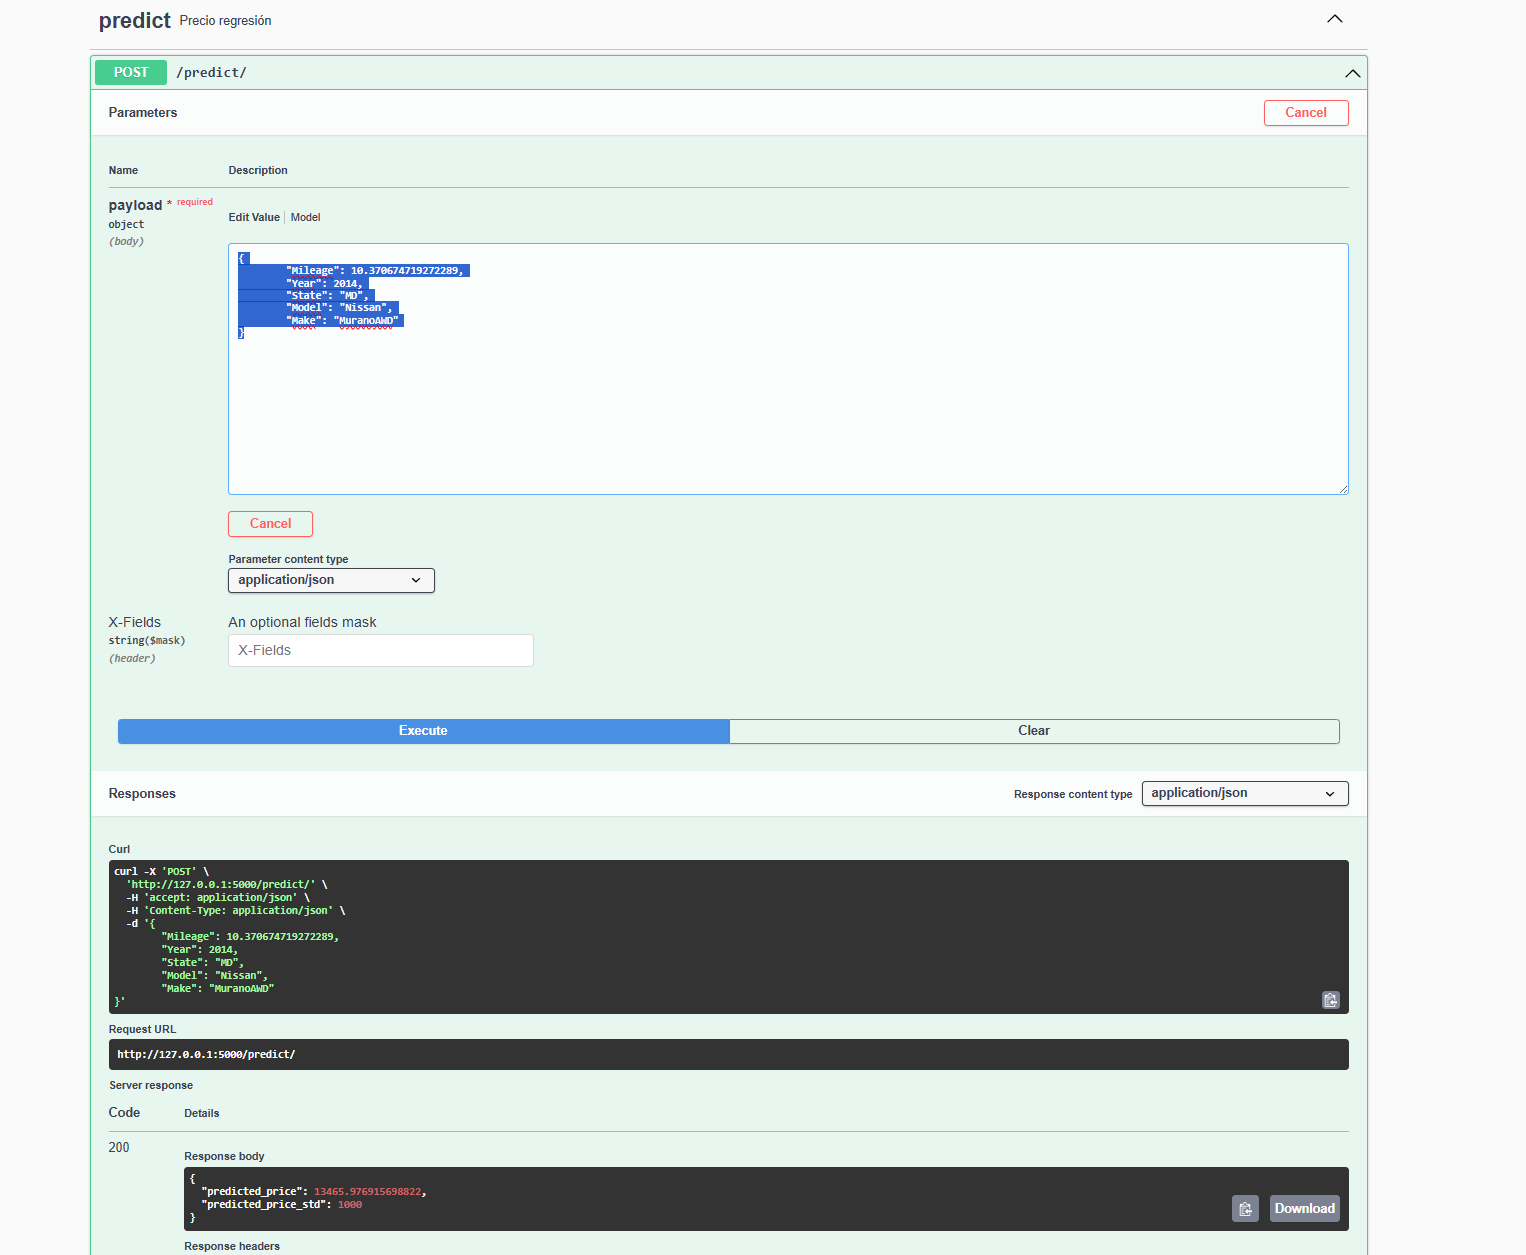

-----------------------------------API - GET

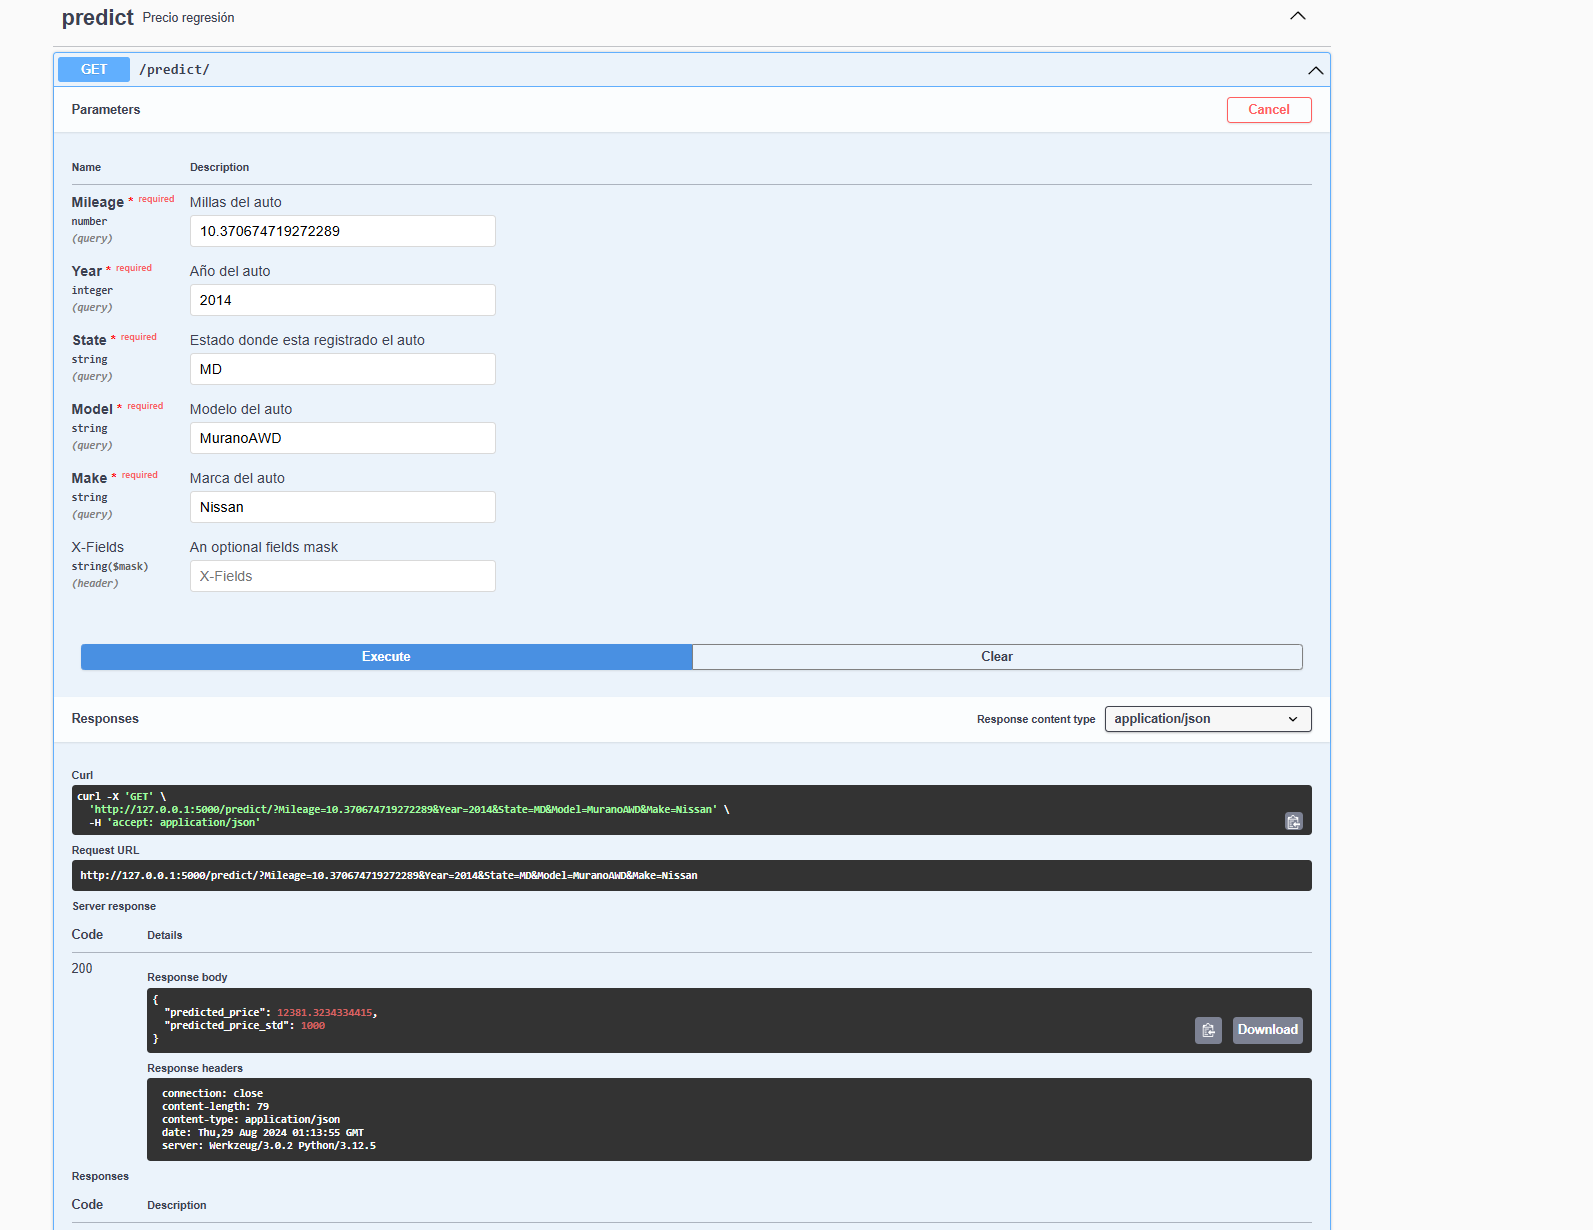

-----------------------------------APi en rube servicio de render

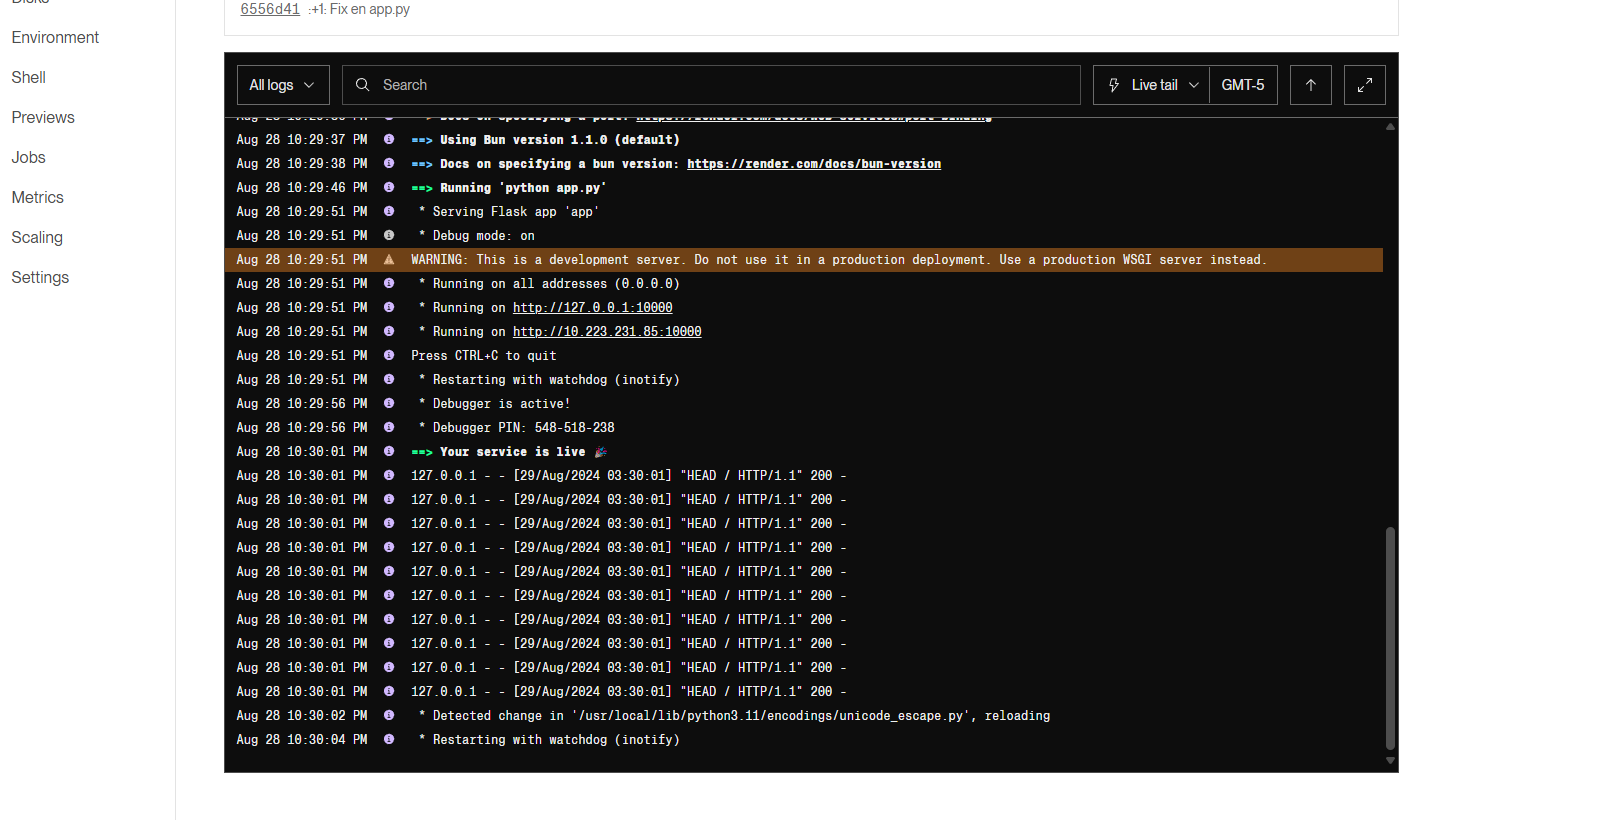

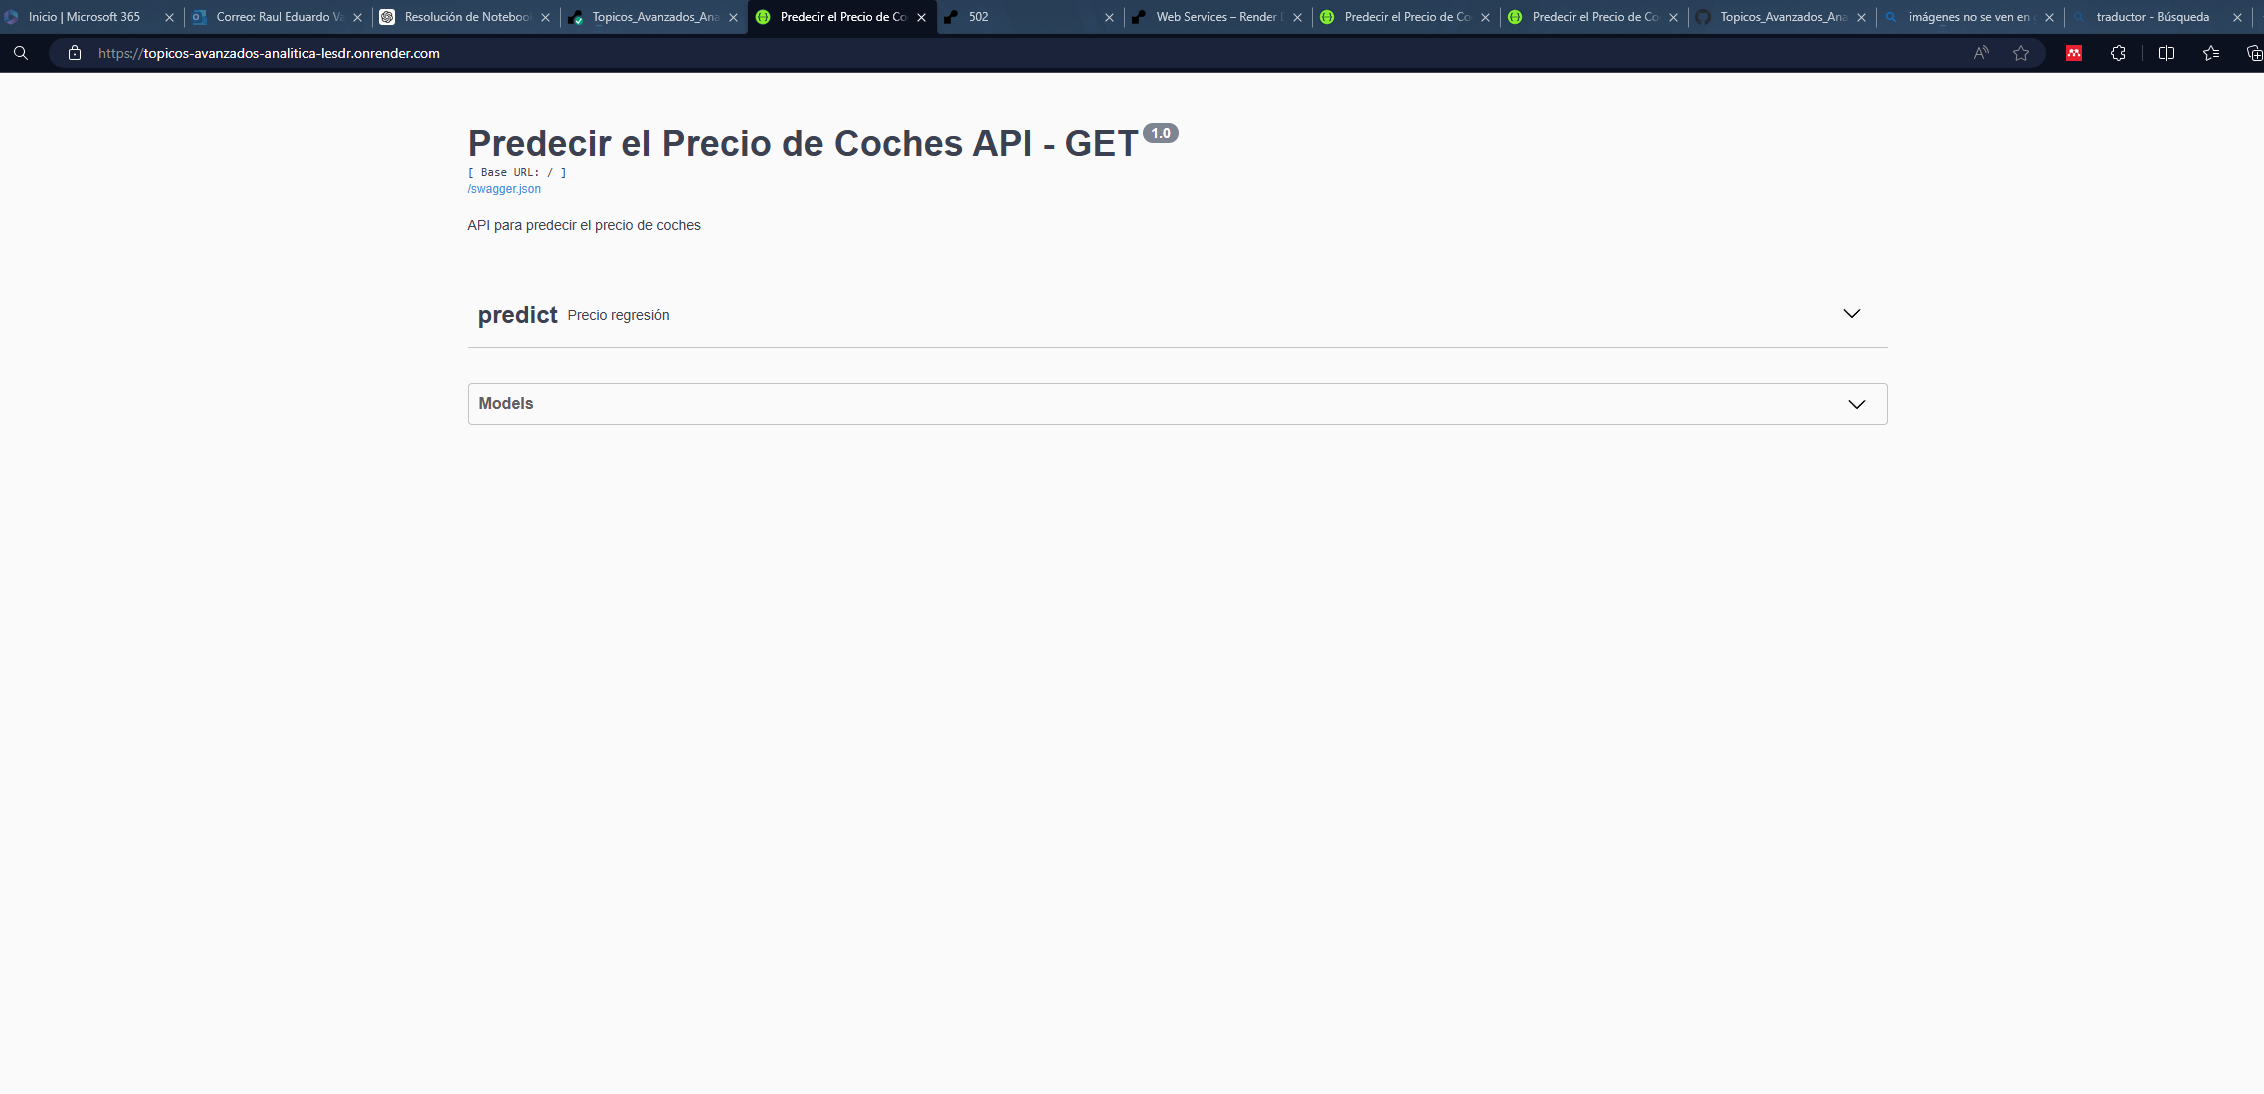

-----------------------------------Api local 

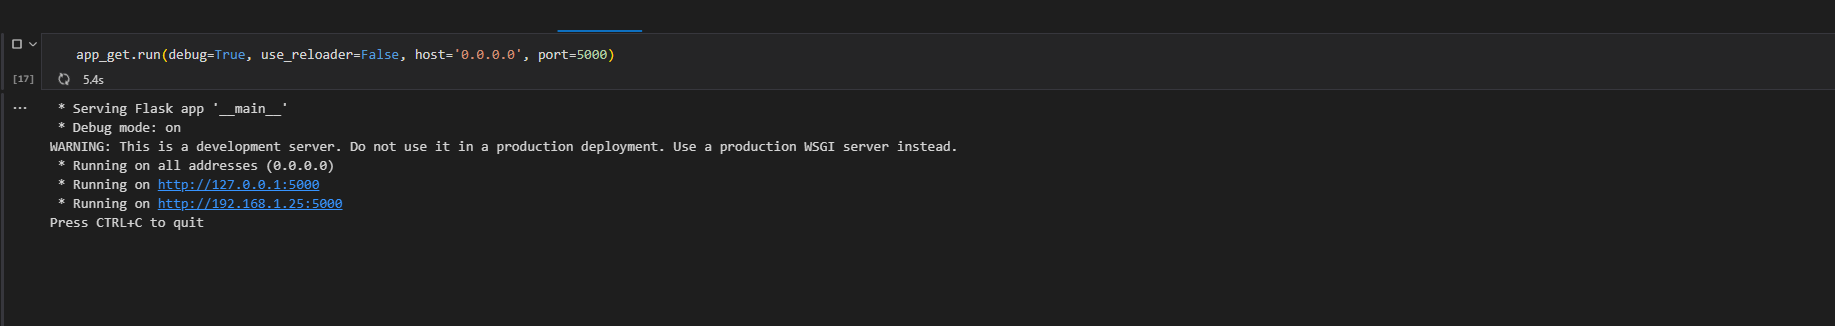

#### Evaluation:
- 40% - API hosted on a cloud service
- 10% - Show screenshots of the model doing the predictions on the local machine


# publicación Api

Generacíon de archivo de requerimientos

In [2]:
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


# Creacion archivo app.py para publicacion en RENDER

In [13]:

codigo = """
import os
from flask import Flask
from flask_restx import Api, Resource, fields
import Model_Dev

app = Flask(__name__)
api = Api(
    app_post,
    version='1.0',
    title='Predecir el Precio de Coches API - POST',
    description='API para predecir el precio de coches')

ns = api.namespace('predict', description='Precio regresión')

# Definir el modelo del cuerpo de la solicitud
input_model = api.model('InputModel', {
    'Mileage': fields.Float(required=True, description='Millas del auto'),
    'Year': fields.Integer(required=True, description='Año del auto'),
    'State': fields.String(required=True, description='Estado donde esta registrado el auto'),
    'Model': fields.String(required=True, description='Modelo del auto'),
    'Make': fields.String(required=True, description='Marca del auto')
})

resource_fields = api.model('Resource', {
    'predicted_price': fields.Float,
    'predicted_price_std': fields.Float,
})

@ns.route('/')
class PredictPrice(Resource):
    @api.expect(parser)
    @api.marshal_with(resource_fields)
    def get(self):
        # Obtener los parámetros de la URL
        args = parser.parse_args()
        mileage = args['Mileage']
        year = args['Year']
        state = args['State']
        model_name = args['Model']
        make = args['Make']

        # Realizar la predicción
        predicted_price, predicted_price_std = Model_Dev.predict_price(
            mileage=mileage, 
            year=year, 
            state=state, 
            model=model_name,  # Usar model_name en lugar de model
            make=make
        )

        return {
            "predicted_price": predicted_price,
            'predicted_price_std': predicted_price_std
        }, 200

if __name__ == '__main__':
    port = int(os.environ.get('PORT', 5000))
    app.run(host='0.0.0.0', port=port, debug=True)
"""

# Definir la ruta donde se guardará el archivo .py
folder_path = 'model_deployment'
file_name = 'app.py'
file_path = os.path.join(folder_path, file_name)

# Verificar si el directorio existe, si no, crearlo
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Escribir el código en el archivo .py
with open(file_path, 'w', encoding='utf-8') as file:
    file.write(codigo)

print(f"Archivo {file_name} creado exitosamente en {folder_path}")

Archivo app.py creado exitosamente en model_deployment


In [11]:

codigo = """
import os
from flask import Flask
from flask_restx import Api, Resource, fields
import Model_Dev

app = Flask(__name__)
api = Api(
    app,
    version='1.0',
    title='Predecir el Precio de Coches API - GET',
    description='API para predecir el precio de coches'
)

ns = api.namespace('predict', description='Precio regresión')

# Definir los argumentos esperados
parser = api.parser()

parser.add_argument(
    'Mileage',
    type=float,
    required=True,
    help='Millas del auto',
    location='args')

parser.add_argument(
    'Year',
    type=int,
    required=True,
    help='Año del auto',
    location='args')

parser.add_argument(
    'State',
    type=str,
    required=True,
    help='Estado donde está registrado el auto',
    location='args')

parser.add_argument(
    'Model',
    type=str,
    required=True,
    help='Modelo del auto',
    location='args')

parser.add_argument(
    'Make',
    type=str,
    required=True,
    help='Marca del auto',
    location='args')

resource_fields = api.model('Resource', {
    'predicted_price': fields.Float,
    'predicted_price_std': fields.Float,
})

@ns.route('/')
class PredictPrice(Resource):
    @api.expect(parser)
    @api.marshal_with(resource_fields)
    def get(self):
        # Obtener los parámetros de la URL
        args = parser.parse_args()
        mileage = args['Mileage']
        year = args['Year']
        state = args['State']
        model_name = args['Model']
        make = args['Make']

        # Realizar la predicción
        predicted_price, predicted_price_std = Model_Dev.predict_price(
            mileage=mileage, 
            year=year, 
            state=state, 
            model=model_name,  # Usar model_name en lugar de model
            make=make
        )

        return {
            "predicted_price": predicted_price,
            'predicted_price_std': predicted_price_std
        }, 200

if __name__ == '__main__':
    port = int(os.environ.get('PORT', 5000))
    app.run(host='0.0.0.0', port=port, debug=True)
"""
# Definir la ruta donde se guardará el archivo .py
folder_path = 'model_deployment'
file_name = 'app.py'
file_path = os.path.join(folder_path, file_name)

# Verificar si el directorio existe, si no, crearlo
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Escribir el código en el archivo .py
with open(file_path, 'w', encoding='utf-8') as file:
    file.write(codigo)

print(f"Archivo {file_name} creado exitosamente en {folder_path}")

Archivo app.py creado exitosamente en model_deployment
